In [130]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
df = pd.read_csv("framingham.csv")
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [133]:
df.nunique()

male                  2
age                  39
education             4
currentSmoker         2
cigsPerDay           33
BPMeds                2
prevalentStroke       2
prevalentHyp          2
diabetes              2
totChol             248
sysBP               234
diaBP               146
BMI                1364
heartRate            73
glucose             143
TenYearCHD            2
dtype: int64

In [134]:
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [135]:
for i in df.columns:
    print(i,len(df[df[i] == '?']))

male 0
age 0
education 0
currentSmoker 0
cigsPerDay 0
BPMeds 0
prevalentStroke 0
prevalentHyp 0
diabetes 0
totChol 0
sysBP 0
diaBP 0
BMI 0
heartRate 0
glucose 0
TenYearCHD 0


In [136]:
for i in df.columns:
    print(i,len(df[df[i] == 0]))

male 2420
age 0
education 0
currentSmoker 2145
cigsPerDay 2145
BPMeds 4063
prevalentStroke 4215
prevalentHyp 2923
diabetes 4131
totChol 0
sysBP 0
diaBP 0
BMI 0
heartRate 0
glucose 0
TenYearCHD 3596


In [137]:
df = df.drop_duplicates()


### As always creating numerical columns and categorical columns

### be aware that there are some binary and discrete features that should be count as categorical features 

In [138]:
numerical_cols = ["age","cigsPerDay","totChol",	"sysBP",	"diaBP",	"BMI",	"heartRate",	"glucose",	]
categorical_cols = ["male",		"education",	"currentSmoker","BPMeds",	"prevalentStroke",	"prevalentHyp",	"diabetes"]

## The dataset is so imbalanced and has some missing values 

## Missing value imputation 

I will use mode imputation for categorical columns

I will use two methods for impute the missing values in the numerical columns <br>
- using median 
- using KNN imputer 

Then I will use a Random Forest classifier and calculate R2 to evaluate the methods 

In [139]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["TenYearCHD"], axis=1), df["TenYearCHD"], train_size=0.6, test_size=0.4,random_state=0)

In [140]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=100)),
])

In [141]:
categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

In [142]:
# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categoric_transformer, categorical_cols),
    ])

In [143]:
pipeline = Pipeline(
    steps=[
        ('preprocessor' , preprocessor),
        ("model" , RandomForestClassifier(n_jobs = -1 , random_state=42))
    ]
)

In [144]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Calculate mean and standard deviation of R2 scores
mean_r2 = cv_scores.mean()
std_r2 = cv_scores.std()

print(f"Mean R2 score: {mean_r2}")
print(f"Standard deviation of R2 score: {std_r2}")

Mean R2 score: -0.20416823290535385
Standard deviation of R2 score: 0.03931799845833265


### Repeating the whole process with median imputer for numerical columns 

In [145]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [146]:
categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

In [147]:
# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categoric_transformer, categorical_cols),
    ])

In [148]:
pipeline = Pipeline(
    steps=[
        ('preprocessor' , preprocessor),
        ("model" , RandomForestClassifier(n_jobs = -1 , random_state=42))
    ]
)

In [149]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Calculate mean and standard deviation of R2 scores
mean_r2 = cv_scores.mean()
std_r2 = cv_scores.std()

print(f"Mean R2 score: {mean_r2}")
print(f"Standard deviation of R2 score: {std_r2}")

Mean R2 score: -0.21016175660273392
Standard deviation of R2 score: 0.03680605528988713


### KNN is slighly better imupter 

In [150]:
# Initialize KNNImputer with desired parameters
imputer = KNNImputer(n_neighbors=100)
col_imputer = SimpleImputer(strategy='most_frequent')
# Fit the imputer on your DataFrame and transform it to impute missing values
df[numerical_cols]= pd.DataFrame(imputer.fit_transform(df[numerical_cols]), columns=numerical_cols)
df[categorical_cols]= pd.DataFrame(col_imputer.fit_transform(df[categorical_cols]), columns=categorical_cols)

## Select K best 

In [151]:
# Separate features (X) and target variable (y)
X = df.drop(columns=['TenYearCHD'])
y = df['TenYearCHD']

k_best_selector = SelectKBest(score_func=chi2, k=10)  # Select top 10 features
X_best_features = k_best_selector.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = k_best_selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_feature_indices]


In [152]:
selected_features

Index(['male', 'age', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes',
       'totChol', 'sysBP', 'diaBP', 'glucose'],
      dtype='object')

In [153]:
df = df.loc[: , np.append(selected_features,'TenYearCHD')]

In [154]:
df 

,male,age,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,glucose,TenYearCHD
0,1.0,39.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,77.00,0
1,0.0,46.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,76.00,0
2,1.0,48.0,20.0,0.0,0.0,0.0,245.0,127.5,80.0,70.00,0
3,0.0,61.0,30.0,0.0,1.0,0.0,225.0,150.0,95.0,103.00,1
4,0.0,46.0,23.0,0.0,0.0,0.0,285.0,130.0,84.0,85.00,0
...,...,...,...,...,...,...,...,...,...,...,...
4235,0.0,48.0,20.0,0.0,0.0,0.0,248.0,131.0,72.0,86.00,0
4236,0.0,44.0,15.0,0.0,0.0,0.0,210.0,126.5,87.0,80.93,0
4237,0.0,52.0,0.0,0.0,0.0,0.0,269.0,133.5,83.0,107.00,0
4238,1.0,40.0,0.0,0.0,1.0,0.0,185.0,141.0,98.0,72.00,0


## Training KNN 

In [155]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["TenYearCHD"], axis=1), df["TenYearCHD"], train_size=0.6, test_size=0.4,random_state=0)

### Oversampling

In [156]:
sm = SMOTE(random_state=2)

print("\nClass 1 before Over Sampling --> ", sum(y_train == 1))
print("\nClass 0 before Over Sampling --> ", sum(y_train == 0))

X_train, y_train = sm.fit_resample(X_train, y_train)

print("\nThe shape of X after Over Sampling -->", X_train.shape)
print("\nThe shape of Y after Over Sampling -->", y_train.shape)

print("\nClass 1 after Over Sampling --> ", sum(y_train == 1))
print("\nClass 0 after Over Sampling --> ", sum(y_train == 0))
print("\n")


Class 1 before Over Sampling -->  394

Class 0 before Over Sampling -->  2150

The shape of X after Over Sampling --> (4300, 10)

The shape of Y after Over Sampling --> (4300,)

Class 1 after Over Sampling -->  2150

Class 0 after Over Sampling -->  2150




In [157]:
pipeline = Pipeline(
    steps=[
        ('scaler' , StandardScaler()),
        ("model" , KNeighborsClassifier(n_neighbors=3))
    ]
)

In [158]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=3))])

In [159]:
preds = pipeline.predict(X_valid)

In [160]:
R2 = r2_score(y_valid , preds)
R2

-1.4208464730290458

In [161]:
accuracy = accuracy_score(y_valid, preds)
accuracy

0.6957547169811321

## Plotting confusion matrix

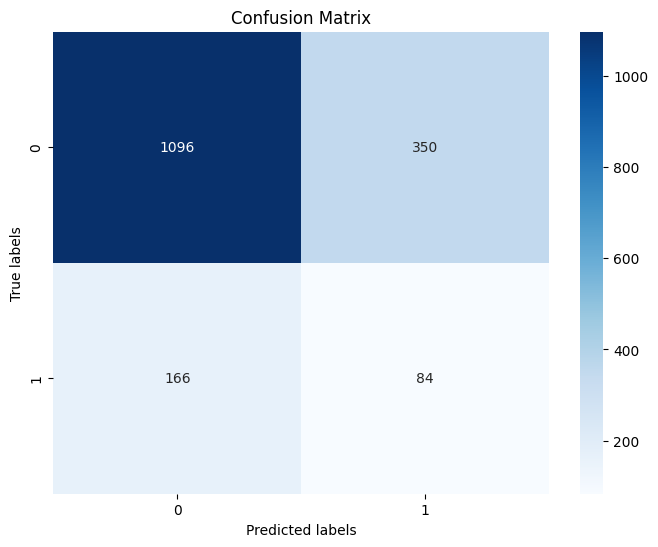

In [162]:
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_valid, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Using Different distances

### manhattan

In [163]:
pipeline = Pipeline(
    steps=[
        ('scaler' , StandardScaler()),
        ("model" , KNeighborsClassifier(n_neighbors=3, metric='manhattan'))
    ]
)

In [164]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

In [165]:
preds = pipeline.predict(X_valid)

In [166]:
R2 = r2_score(y_valid , preds)
R2

-1.2613333333333334

In [167]:
accuracy = accuracy_score(y_valid, preds)
accuracy

0.7158018867924528

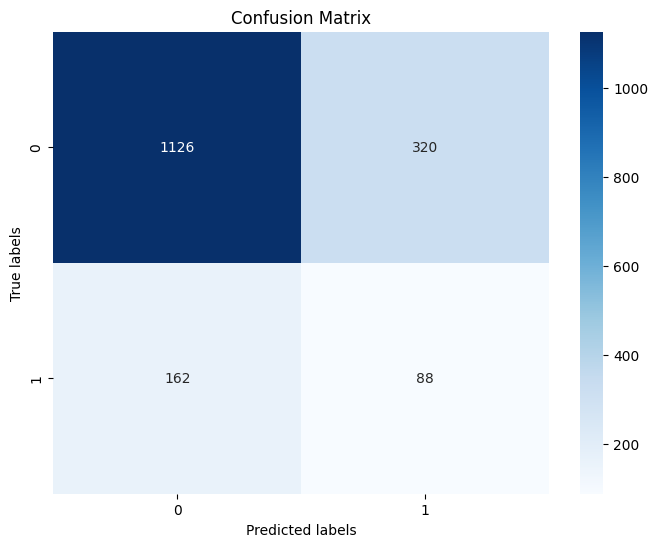

In [168]:
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_valid, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Cosine

In [169]:
pipeline = Pipeline(
    steps=[
        ('scaler' , StandardScaler()),
        ("model" , KNeighborsClassifier(n_neighbors=3, metric='cosine'))
    ]
)

In [170]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='cosine', n_neighbors=3))])

In [171]:
preds = pipeline.predict(X_valid)

In [172]:
R2 = r2_score(y_valid , preds)
R2

-1.4020802213001384

In [173]:
accuracy = accuracy_score(y_valid, preds)
accuracy

0.6981132075471698

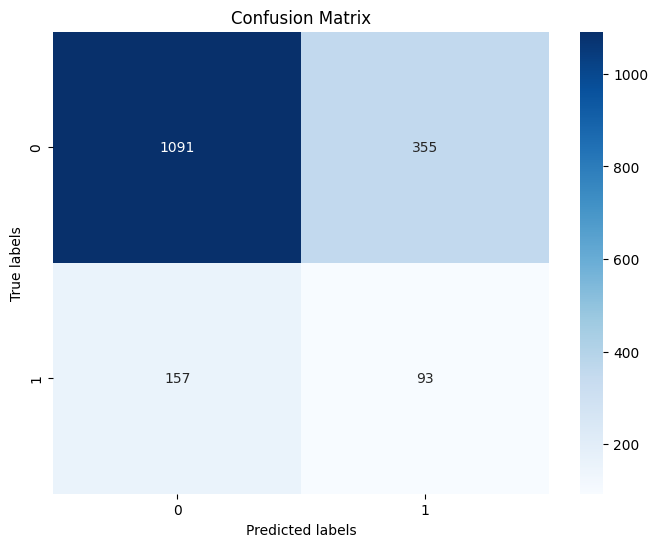

In [174]:
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_valid, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### The task is done 

## But wait!

## outlier detection may yields to better results (I want that extra points :') )

In [175]:
numerical_cols = ["age","totChol",	"sysBP",	"diaBP","glucose"]

In [176]:
# Handling outliers using the IQR method
def handle_outliers_with_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

for col in numerical_cols:
    handle_outliers_with_IQR(df, col)

In [177]:
df

,male,age,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,glucose,TenYearCHD
0,1.0,39.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,77.00,0
1,0.0,46.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,76.00,0
2,1.0,48.0,20.0,0.0,0.0,0.0,245.0,127.5,80.0,70.00,0
3,0.0,61.0,30.0,0.0,1.0,0.0,225.0,150.0,95.0,103.00,1
4,0.0,46.0,23.0,0.0,0.0,0.0,285.0,130.0,84.0,85.00,0
...,...,...,...,...,...,...,...,...,...,...,...
4235,0.0,48.0,20.0,0.0,0.0,0.0,248.0,131.0,72.0,86.00,0
4236,0.0,44.0,15.0,0.0,0.0,0.0,210.0,126.5,87.0,80.93,0
4237,0.0,52.0,0.0,0.0,0.0,0.0,269.0,133.5,83.0,107.00,0
4238,1.0,40.0,0.0,0.0,1.0,0.0,185.0,141.0,98.0,72.00,0


In [178]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(["TenYearCHD"], axis=1), df["TenYearCHD"], train_size=0.6, test_size=0.4,random_state=0)

In [179]:
pipeline = Pipeline(
    steps=[
        ('scaler' , StandardScaler()),
        ("model" , KNeighborsClassifier(n_neighbors=3, metric='manhattan'))
    ]
)

In [180]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

In [181]:
preds = pipeline.predict(X_valid)

In [182]:
R2 = r2_score(y_valid , preds)
R2

-0.48253388658367924

In [183]:
accuracy = accuracy_score(y_valid, preds)
accuracy

0.8136792452830188

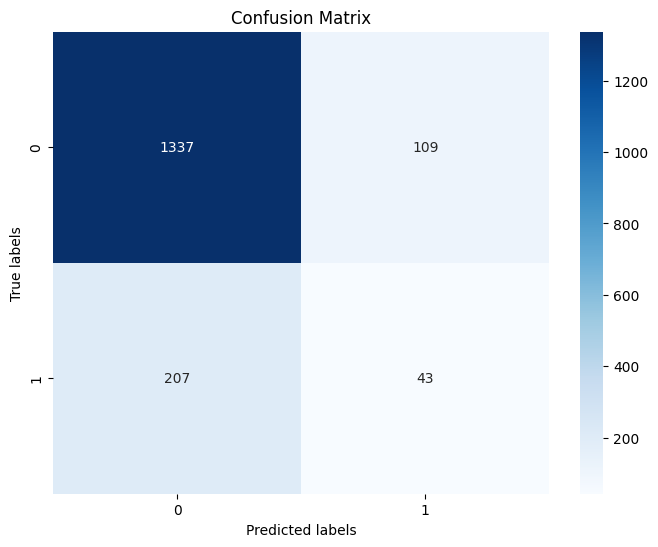

In [184]:
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_valid, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Results improved 